### Importing basic libraries

In [30]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

### Reading the csv file

In [31]:
df=pd.read_csv('/content/qa_medical.csv')

In [32]:
df.head()

,qtype,Question,Answer
0,susceptibility,Who is at risk for Lymphocytic Choriomeningiti...,LCMV infections can occur after exposure to fr...
1,symptoms,What are the symptoms of Lymphocytic Choriomen...,LCMV is most commonly recognized as causing ne...
2,susceptibility,Who is at risk for Lymphocytic Choriomeningiti...,Individuals of all ages who come into contact ...
3,exams and tests,How to diagnose Lymphocytic Choriomeningitis (...,"During the first phase of the disease, the mos..."
4,treatment,What are the treatments for Lymphocytic Chorio...,"Aseptic meningitis, encephalitis, or meningoen..."


In [33]:
df.isnull().sum()

qtype       0
Question    0
Answer      0
dtype: int64

### Keeping only 'Answer' Column which will later be stored as embeddings in the deeplake vector database

In [34]:
df=df.drop(columns=['qtype','Question'])

In [35]:
df['Answer'].str.len()

0         467
1        2558
2         708
3         653
4         446
         ... 
16402    1820
16403     993
16404    1478
16405     658
16406     617
Name: Answer, Length: 16407, dtype: int64

In [36]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16407 entries, 0 to 16406
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Answer  16407 non-null  object
dtypes: object(1)
memory usage: 128.3+ KB


### Plotting the length of first 100 data points to get an idea of length of the data points

<Axes: >

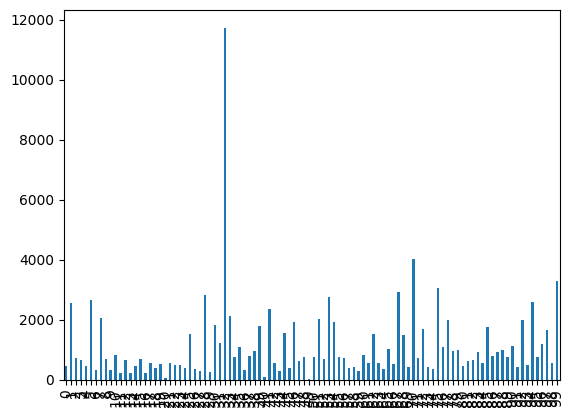

In [37]:
df['Answer'][:100].str.len().plot(kind='bar')

In [38]:
df[df['Answer'].apply(len) < 200]

,Answer
20,General guidelines for safe seafood consumption:
40,Frequently Asked Questions (FAQs)\n \n \...
49,Topics
128,Frequently Asked Questions (FAQs)\n \n V...
133,Loiasis is an infection caused by the parasiti...
...,...
15868,Tay syndrome is a rare genetic disorder charac...
16097,How is oculopharyngeal muscular dystrophy inhe...
16111,How might congenital anosmia be treated? Unfor...
16136,Are chronic hiccups inherited? Chronic hiccups...


### Keeping only those data points having length less than 200

#### Because it will take a lot of time and credits of OpenAI to store embedding of  all datapoints in vector database

In [39]:
df=df[df['Answer'].apply(len) < 200]

In [40]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1120 entries, 20 to 16307
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Answer  1120 non-null   object
dtypes: object(1)
memory usage: 17.5+ KB


### Keeping all answers to a list

In [41]:
answers = df['Answer'].tolist()

In [42]:
answers[0]

'General guidelines for safe seafood consumption:'

### Installation of necessary packages

In [43]:
!pip install langchain==0.0.208 deeplake openai==0.27.8 tiktoken

### Setting up the API keys

In [44]:
import os
os.environ['OPENAI_API_KEY']='please update with your api key'
os.environ['ACTIVELOOP_TOKEN']='please update with your activeloop api'


### Importing Further necessary Libraries

In [45]:
from langchain.embeddings.openai import OpenAIEmbeddings
from langchain.vectorstores import DeepLake
from langchain.text_splitter import CharacterTextSplitter
from langchain import OpenAI
from langchain.document_loaders import SeleniumURLLoader
from langchain import PromptTemplate

In [52]:
# 1: Split the documents into chunks and compute their embeddings

### Convering list of Answers in to Documents

In [53]:
from langchain.schema import Document
# Extract answers and convert them to Document objects
documents = [Document(page_content=answer) for answer in df['Answer'].tolist()]


In [54]:
documents[0]

Document(page_content='General guidelines for safe seafood consumption:', metadata={})

### Total length of documents

In [55]:
len(documents)

1120

### Initiating CharacterTextSplitter and splitting the documents in to chunks

In [56]:
# Initialize CharacterTextSplitter
text_splitter = CharacterTextSplitter(chunk_size=5000, chunk_overlap=1000)

# Split the documents into chunks
docs = text_splitter.split_documents(documents)

In [57]:
len(docs)

1120

### Embedding the docs and adding it to the Deep Lake dataset

In [58]:
embeddings = OpenAIEmbeddings(model="text-embedding-ada-002")

# creating Deep Lake dataset
my_activeloop_org_id = "siftain"
my_activeloop_dataset_name = "langchain_course_MEDICAL_Answer_BoT"
dataset_path = f"hub://{my_activeloop_org_id}/{my_activeloop_dataset_name}"
db = DeepLake(dataset_path=dataset_path, embedding_function=embeddings)

# Adding documents to the Deep Lake dataset
# This step processes each document separately to avoid rate limits
batch_size = 32 # Defining a batch size to avoid rate limits
for i in range(0, len(docs), batch_size):
    batch = docs[i:i+batch_size]
    db.add_documents(batch)

Your Deep Lake dataset has been successfully created!


Creating 32 embeddings in 1 batches of size 32:: 100%|██████████| 1/1 [01:25<00:00, 85.90s/it]


Dataset(path='hub://siftain/langchain_course_MEDICAL_Answer_BoT', tensors=['text', 'metadata', 'embedding', 'id'])

  tensor      htype      shape      dtype  compression
  -------    -------    -------    -------  ------- 
   text       text      (32, 1)      str     None   
 metadata     json      (32, 1)      str     None   
 embedding  embedding  (32, 1536)  float32   None   
    id        text      (32, 1)      str     None   


Creating 32 embeddings in 1 batches of size 32:: 100%|██████████| 1/1 [01:18<00:00, 78.38s/it]


Dataset(path='hub://siftain/langchain_course_MEDICAL_Answer_BoT', tensors=['text', 'metadata', 'embedding', 'id'])

  tensor      htype      shape      dtype  compression
  -------    -------    -------    -------  ------- 
   text       text      (64, 1)      str     None   
 metadata     json      (64, 1)      str     None   
 embedding  embedding  (64, 1536)  float32   None   
    id        text      (64, 1)      str     None   


Creating 32 embeddings in 1 batches of size 32:: 100%|██████████| 1/1 [01:40<00:00, 100.02s/it]


Dataset(path='hub://siftain/langchain_course_MEDICAL_Answer_BoT', tensors=['text', 'metadata', 'embedding', 'id'])

  tensor      htype      shape      dtype  compression
  -------    -------    -------    -------  ------- 
   text       text      (96, 1)      str     None   
 metadata     json      (96, 1)      str     None   
 embedding  embedding  (96, 1536)  float32   None   
    id        text      (96, 1)      str     None   


Creating 32 embeddings in 1 batches of size 32:: 100%|██████████| 1/1 [01:16<00:00, 76.63s/it]


Dataset(path='hub://siftain/langchain_course_MEDICAL_Answer_BoT', tensors=['text', 'metadata', 'embedding', 'id'])

  tensor      htype       shape      dtype  compression
  -------    -------     -------    -------  ------- 
   text       text      (128, 1)      str     None   
 metadata     json      (128, 1)      str     None   
 embedding  embedding  (128, 1536)  float32   None   
    id        text      (128, 1)      str     None   


Creating 32 embeddings in 1 batches of size 32:: 100%|██████████| 1/1 [01:15<00:00, 75.40s/it]


Dataset(path='hub://siftain/langchain_course_MEDICAL_Answer_BoT', tensors=['text', 'metadata', 'embedding', 'id'])

  tensor      htype       shape      dtype  compression
  -------    -------     -------    -------  ------- 
   text       text      (160, 1)      str     None   
 metadata     json      (160, 1)      str     None   
 embedding  embedding  (160, 1536)  float32   None   
    id        text      (160, 1)      str     None   


Creating 32 embeddings in 1 batches of size 32:: 100%|██████████| 1/1 [01:25<00:00, 85.14s/it]


Dataset(path='hub://siftain/langchain_course_MEDICAL_Answer_BoT', tensors=['text', 'metadata', 'embedding', 'id'])

  tensor      htype       shape      dtype  compression
  -------    -------     -------    -------  ------- 
   text       text      (192, 1)      str     None   
 metadata     json      (192, 1)      str     None   
 embedding  embedding  (192, 1536)  float32   None   
    id        text      (192, 1)      str     None   


Creating 32 embeddings in 1 batches of size 32:: 100%|██████████| 1/1 [01:29<00:00, 89.49s/it]


Dataset(path='hub://siftain/langchain_course_MEDICAL_Answer_BoT', tensors=['text', 'metadata', 'embedding', 'id'])

  tensor      htype       shape      dtype  compression
  -------    -------     -------    -------  ------- 
   text       text      (224, 1)      str     None   
 metadata     json      (224, 1)      str     None   
 embedding  embedding  (224, 1536)  float32   None   
    id        text      (224, 1)      str     None   


Creating 32 embeddings in 1 batches of size 32:: 100%|██████████| 1/1 [01:16<00:00, 76.03s/it]


Dataset(path='hub://siftain/langchain_course_MEDICAL_Answer_BoT', tensors=['text', 'metadata', 'embedding', 'id'])

  tensor      htype       shape      dtype  compression
  -------    -------     -------    -------  ------- 
   text       text      (256, 1)      str     None   
 metadata     json      (256, 1)      str     None   
 embedding  embedding  (256, 1536)  float32   None   
    id        text      (256, 1)      str     None   


Creating 32 embeddings in 1 batches of size 32:: 100%|██████████| 1/1 [01:02<00:00, 62.95s/it]


Dataset(path='hub://siftain/langchain_course_MEDICAL_Answer_BoT', tensors=['text', 'metadata', 'embedding', 'id'])

  tensor      htype       shape      dtype  compression
  -------    -------     -------    -------  ------- 
   text       text      (288, 1)      str     None   
 metadata     json      (288, 1)      str     None   
 embedding  embedding  (288, 1536)  float32   None   
    id        text      (288, 1)      str     None   


Creating 32 embeddings in 1 batches of size 32:: 100%|██████████| 1/1 [00:50<00:00, 50.56s/it]


Dataset(path='hub://siftain/langchain_course_MEDICAL_Answer_BoT', tensors=['text', 'metadata', 'embedding', 'id'])

  tensor      htype       shape      dtype  compression
  -------    -------     -------    -------  ------- 
   text       text      (320, 1)      str     None   
 metadata     json      (320, 1)      str     None   
 embedding  embedding  (320, 1536)  float32   None   
    id        text      (320, 1)      str     None   


Creating 32 embeddings in 1 batches of size 32:: 100%|██████████| 1/1 [00:59<00:00, 59.65s/it]


Dataset(path='hub://siftain/langchain_course_MEDICAL_Answer_BoT', tensors=['text', 'metadata', 'embedding', 'id'])

  tensor      htype       shape      dtype  compression
  -------    -------     -------    -------  ------- 
   text       text      (352, 1)      str     None   
 metadata     json      (352, 1)      str     None   
 embedding  embedding  (352, 1536)  float32   None   
    id        text      (352, 1)      str     None   


Creating 32 embeddings in 1 batches of size 32:: 100%|██████████| 1/1 [00:57<00:00, 57.20s/it]


Dataset(path='hub://siftain/langchain_course_MEDICAL_Answer_BoT', tensors=['text', 'metadata', 'embedding', 'id'])

  tensor      htype       shape      dtype  compression
  -------    -------     -------    -------  ------- 
   text       text      (384, 1)      str     None   
 metadata     json      (384, 1)      str     None   
 embedding  embedding  (384, 1536)  float32   None   
    id        text      (384, 1)      str     None   


Creating 32 embeddings in 1 batches of size 32:: 100%|██████████| 1/1 [01:05<00:00, 65.01s/it]


Dataset(path='hub://siftain/langchain_course_MEDICAL_Answer_BoT', tensors=['text', 'metadata', 'embedding', 'id'])

  tensor      htype       shape      dtype  compression
  -------    -------     -------    -------  ------- 
   text       text      (416, 1)      str     None   
 metadata     json      (416, 1)      str     None   
 embedding  embedding  (416, 1536)  float32   None   
    id        text      (416, 1)      str     None   


Creating 32 embeddings in 1 batches of size 32:: 100%|██████████| 1/1 [00:58<00:00, 58.62s/it]


Dataset(path='hub://siftain/langchain_course_MEDICAL_Answer_BoT', tensors=['text', 'metadata', 'embedding', 'id'])

  tensor      htype       shape      dtype  compression
  -------    -------     -------    -------  ------- 
   text       text      (448, 1)      str     None   
 metadata     json      (448, 1)      str     None   
 embedding  embedding  (448, 1536)  float32   None   
    id        text      (448, 1)      str     None   


Creating 32 embeddings in 1 batches of size 32:: 100%|██████████| 1/1 [01:15<00:00, 75.05s/it]


Dataset(path='hub://siftain/langchain_course_MEDICAL_Answer_BoT', tensors=['text', 'metadata', 'embedding', 'id'])

  tensor      htype       shape      dtype  compression
  -------    -------     -------    -------  ------- 
   text       text      (480, 1)      str     None   
 metadata     json      (480, 1)      str     None   
 embedding  embedding  (480, 1536)  float32   None   
    id        text      (480, 1)      str     None   


Creating 32 embeddings in 1 batches of size 32:: 100%|██████████| 1/1 [01:04<00:00, 64.33s/it]


Dataset(path='hub://siftain/langchain_course_MEDICAL_Answer_BoT', tensors=['text', 'metadata', 'embedding', 'id'])

  tensor      htype       shape      dtype  compression
  -------    -------     -------    -------  ------- 
   text       text      (512, 1)      str     None   
 metadata     json      (512, 1)      str     None   
 embedding  embedding  (512, 1536)  float32   None   
    id        text      (512, 1)      str     None   


Creating 32 embeddings in 1 batches of size 32:: 100%|██████████| 1/1 [01:00<00:00, 60.41s/it]


Dataset(path='hub://siftain/langchain_course_MEDICAL_Answer_BoT', tensors=['text', 'metadata', 'embedding', 'id'])

  tensor      htype       shape      dtype  compression
  -------    -------     -------    -------  ------- 
   text       text      (544, 1)      str     None   
 metadata     json      (544, 1)      str     None   
 embedding  embedding  (544, 1536)  float32   None   
    id        text      (544, 1)      str     None   


Creating 32 embeddings in 1 batches of size 32:: 100%|██████████| 1/1 [01:00<00:00, 60.99s/it]


Dataset(path='hub://siftain/langchain_course_MEDICAL_Answer_BoT', tensors=['text', 'metadata', 'embedding', 'id'])

  tensor      htype       shape      dtype  compression
  -------    -------     -------    -------  ------- 
   text       text      (576, 1)      str     None   
 metadata     json      (576, 1)      str     None   
 embedding  embedding  (576, 1536)  float32   None   
    id        text      (576, 1)      str     None   


Creating 32 embeddings in 1 batches of size 32:: 100%|██████████| 1/1 [00:51<00:00, 51.18s/it]


Dataset(path='hub://siftain/langchain_course_MEDICAL_Answer_BoT', tensors=['text', 'metadata', 'embedding', 'id'])

  tensor      htype       shape      dtype  compression
  -------    -------     -------    -------  ------- 
   text       text      (608, 1)      str     None   
 metadata     json      (608, 1)      str     None   
 embedding  embedding  (608, 1536)  float32   None   
    id        text      (608, 1)      str     None   


Creating 32 embeddings in 1 batches of size 32:: 100%|██████████| 1/1 [01:04<00:00, 64.79s/it]


Dataset(path='hub://siftain/langchain_course_MEDICAL_Answer_BoT', tensors=['text', 'metadata', 'embedding', 'id'])

  tensor      htype       shape      dtype  compression
  -------    -------     -------    -------  ------- 
   text       text      (640, 1)      str     None   
 metadata     json      (640, 1)      str     None   
 embedding  embedding  (640, 1536)  float32   None   
    id        text      (640, 1)      str     None   


Creating 32 embeddings in 1 batches of size 32:: 100%|██████████| 1/1 [01:01<00:00, 61.27s/it]


Dataset(path='hub://siftain/langchain_course_MEDICAL_Answer_BoT', tensors=['text', 'metadata', 'embedding', 'id'])

  tensor      htype       shape      dtype  compression
  -------    -------     -------    -------  ------- 
   text       text      (672, 1)      str     None   
 metadata     json      (672, 1)      str     None   
 embedding  embedding  (672, 1536)  float32   None   
    id        text      (672, 1)      str     None   


Creating 32 embeddings in 1 batches of size 32:: 100%|██████████| 1/1 [01:00<00:00, 60.57s/it]


Dataset(path='hub://siftain/langchain_course_MEDICAL_Answer_BoT', tensors=['text', 'metadata', 'embedding', 'id'])

  tensor      htype       shape      dtype  compression
  -------    -------     -------    -------  ------- 
   text       text      (704, 1)      str     None   
 metadata     json      (704, 1)      str     None   
 embedding  embedding  (704, 1536)  float32   None   
    id        text      (704, 1)      str     None   


Creating 32 embeddings in 1 batches of size 32:: 100%|██████████| 1/1 [01:07<00:00, 67.25s/it]


Dataset(path='hub://siftain/langchain_course_MEDICAL_Answer_BoT', tensors=['text', 'metadata', 'embedding', 'id'])

  tensor      htype       shape      dtype  compression
  -------    -------     -------    -------  ------- 
   text       text      (736, 1)      str     None   
 metadata     json      (736, 1)      str     None   
 embedding  embedding  (736, 1536)  float32   None   
    id        text      (736, 1)      str     None   


Creating 32 embeddings in 1 batches of size 32:: 100%|██████████| 1/1 [00:55<00:00, 55.02s/it]


Dataset(path='hub://siftain/langchain_course_MEDICAL_Answer_BoT', tensors=['text', 'metadata', 'embedding', 'id'])

  tensor      htype       shape      dtype  compression
  -------    -------     -------    -------  ------- 
   text       text      (768, 1)      str     None   
 metadata     json      (768, 1)      str     None   
 embedding  embedding  (768, 1536)  float32   None   
    id        text      (768, 1)      str     None   


Creating 32 embeddings in 1 batches of size 32:: 100%|██████████| 1/1 [00:54<00:00, 54.51s/it]


Dataset(path='hub://siftain/langchain_course_MEDICAL_Answer_BoT', tensors=['text', 'metadata', 'embedding', 'id'])

  tensor      htype       shape      dtype  compression
  -------    -------     -------    -------  ------- 
   text       text      (800, 1)      str     None   
 metadata     json      (800, 1)      str     None   
 embedding  embedding  (800, 1536)  float32   None   
    id        text      (800, 1)      str     None   


Creating 32 embeddings in 1 batches of size 32:: 100%|██████████| 1/1 [01:09<00:00, 69.32s/it]


Dataset(path='hub://siftain/langchain_course_MEDICAL_Answer_BoT', tensors=['text', 'metadata', 'embedding', 'id'])

  tensor      htype       shape      dtype  compression
  -------    -------     -------    -------  ------- 
   text       text      (832, 1)      str     None   
 metadata     json      (832, 1)      str     None   
 embedding  embedding  (832, 1536)  float32   None   
    id        text      (832, 1)      str     None   


Creating 32 embeddings in 1 batches of size 32:: 100%|██████████| 1/1 [01:01<00:00, 61.51s/it]


Dataset(path='hub://siftain/langchain_course_MEDICAL_Answer_BoT', tensors=['text', 'metadata', 'embedding', 'id'])

  tensor      htype       shape      dtype  compression
  -------    -------     -------    -------  ------- 
   text       text      (864, 1)      str     None   
 metadata     json      (864, 1)      str     None   
 embedding  embedding  (864, 1536)  float32   None   
    id        text      (864, 1)      str     None   


Creating 32 embeddings in 1 batches of size 32:: 100%|██████████| 1/1 [01:08<00:00, 68.76s/it]


Dataset(path='hub://siftain/langchain_course_MEDICAL_Answer_BoT', tensors=['text', 'metadata', 'embedding', 'id'])

  tensor      htype       shape      dtype  compression
  -------    -------     -------    -------  ------- 
   text       text      (896, 1)      str     None   
 metadata     json      (896, 1)      str     None   
 embedding  embedding  (896, 1536)  float32   None   
    id        text      (896, 1)      str     None   


Creating 32 embeddings in 1 batches of size 32:: 100%|██████████| 1/1 [00:57<00:00, 57.09s/it]


Dataset(path='hub://siftain/langchain_course_MEDICAL_Answer_BoT', tensors=['text', 'metadata', 'embedding', 'id'])

  tensor      htype       shape      dtype  compression
  -------    -------     -------    -------  ------- 
   text       text      (928, 1)      str     None   
 metadata     json      (928, 1)      str     None   
 embedding  embedding  (928, 1536)  float32   None   
    id        text      (928, 1)      str     None   


Creating 32 embeddings in 1 batches of size 32:: 100%|██████████| 1/1 [01:01<00:00, 61.16s/it]


Dataset(path='hub://siftain/langchain_course_MEDICAL_Answer_BoT', tensors=['text', 'metadata', 'embedding', 'id'])

  tensor      htype       shape      dtype  compression
  -------    -------     -------    -------  ------- 
   text       text      (960, 1)      str     None   
 metadata     json      (960, 1)      str     None   
 embedding  embedding  (960, 1536)  float32   None   
    id        text      (960, 1)      str     None   


Creating 32 embeddings in 1 batches of size 32:: 100%|██████████| 1/1 [00:57<00:00, 57.78s/it]


Dataset(path='hub://siftain/langchain_course_MEDICAL_Answer_BoT', tensors=['text', 'metadata', 'embedding', 'id'])

  tensor      htype       shape      dtype  compression
  -------    -------     -------    -------  ------- 
   text       text      (992, 1)      str     None   
 metadata     json      (992, 1)      str     None   
 embedding  embedding  (992, 1536)  float32   None   
    id        text      (992, 1)      str     None   


Creating 32 embeddings in 1 batches of size 32:: 100%|██████████| 1/1 [01:02<00:00, 62.53s/it]


Dataset(path='hub://siftain/langchain_course_MEDICAL_Answer_BoT', tensors=['text', 'metadata', 'embedding', 'id'])

  tensor      htype       shape       dtype  compression
  -------    -------     -------     -------  ------- 
   text       text      (1024, 1)      str     None   
 metadata     json      (1024, 1)      str     None   
 embedding  embedding  (1024, 1536)  float32   None   
    id        text      (1024, 1)      str     None   


Creating 32 embeddings in 1 batches of size 32:: 100%|██████████| 1/1 [01:00<00:00, 60.44s/it]


Dataset(path='hub://siftain/langchain_course_MEDICAL_Answer_BoT', tensors=['text', 'metadata', 'embedding', 'id'])

  tensor      htype       shape       dtype  compression
  -------    -------     -------     -------  ------- 
   text       text      (1056, 1)      str     None   
 metadata     json      (1056, 1)      str     None   
 embedding  embedding  (1056, 1536)  float32   None   
    id        text      (1056, 1)      str     None   


Creating 32 embeddings in 1 batches of size 32:: 100%|██████████| 1/1 [00:51<00:00, 51.93s/it]


Dataset(path='hub://siftain/langchain_course_MEDICAL_Answer_BoT', tensors=['text', 'metadata', 'embedding', 'id'])

  tensor      htype       shape       dtype  compression
  -------    -------     -------     -------  ------- 
   text       text      (1088, 1)      str     None   
 metadata     json      (1088, 1)      str     None   
 embedding  embedding  (1088, 1536)  float32   None   
    id        text      (1088, 1)      str     None   


Creating 32 embeddings in 1 batches of size 32:: 100%|██████████| 1/1 [01:01<00:00, 61.85s/it]

Dataset(path='hub://siftain/langchain_course_MEDICAL_Answer_BoT', tensors=['text', 'metadata', 'embedding', 'id'])

  tensor      htype       shape       dtype  compression
  -------    -------     -------     -------  ------- 
   text       text      (1120, 1)      str     None   
 metadata     json      (1120, 1)      str     None   
 embedding  embedding  (1120, 1536)  float32   None   
    id        text      (1120, 1)      str     None   


### Top relevant document to a specific query

In [82]:

query = "What causes daibetes?"
docs = db.similarity_search(query)
print(docs[0].page_content)

A predisposition to develop type 1 diabetes is passed through generations in families, but the inheritance pattern is unknown.


In [83]:
query = "What causes high blood pressure?"
docs = db.similarity_search(query)
print(docs[0].page_content)

Atherosclerosis, also known as hardening of the arteries, is the most common blood vessel disease. It is caused by the buildup of fatty deposits in the arteries, and is a risk factor for stroke.


### Craft a prompt for GPT-3 using the suggested strategies

In [91]:
# Writing a prompt for a medical question answer support chatbot that
# answer questions using information extracted from our db.
template = """
You are an exceptional medical question-answer chatbot that gently and precisely answers questions related to medical and healthcare.

You know the following context information:

{chunks_formatted}

Answer the following question from a user. Use only information from the provided context. Do not invent information. If the answer to the question is not available in the data or if the question is not related to healthcare or medicine, simply respond with "The information requested is not available in the data provided."

Question: {query}

Answer:
"""

prompt = PromptTemplate(
    input_variables=["chunks_formatted", "query"],
    template=template,
)

### Generating an Answer Based on Retrieved Document Chunks with Adjustable Temperature

#### Multiple examples

In [95]:
# user question
query = input("Please enter your question: ")
temperature = float(input("Please enter the temperature (Randomness): "))

# retrieve relevant chunks
docs = db.similarity_search(query)
retrieved_chunks = [doc.page_content for doc in docs]

# format the prompt
chunks_formatted = "\n\n".join(retrieved_chunks)
prompt_formatted = prompt.format(chunks_formatted=chunks_formatted, query=query)

# generate answer
llm = OpenAI(model="gpt-3.5-turbo-instruct", temperature=temperature)
answer = llm(prompt_formatted)
# Print each sentence in the new line
for sentence in answer.split('. '):
    print(sentence + '.' if sentence else '')

Please enter your question: What causes anxiety?
Please enter the temperature (Randomness): 0

The exact cause of anxiety disorders is not fully understood, but it is believed to be a combination of genetic, environmental, and psychological factors.
Some research suggests that imbalances in certain brain chemicals, such as serotonin and dopamine, may play a role in the development of anxiety disorders.
Additionally, traumatic life events, chronic stress, and certain medical conditions may also contribute to the development of anxiety..


In [96]:
# user question
query = input("Please enter your question: ")
temperature = float(input("Please enter the temperature (Randomness): "))

# retrieve relevant chunks
docs = db.similarity_search(query)
retrieved_chunks = [doc.page_content for doc in docs]

# format the prompt
chunks_formatted = "\n\n".join(retrieved_chunks)
prompt_formatted = prompt.format(chunks_formatted=chunks_formatted, query=query)

# generate answer
llm = OpenAI(model="gpt-3.5-turbo-instruct", temperature=temperature)
answer = llm(prompt_formatted)
# Print each sentence in the new line
for sentence in answer.split('. '):
    print(sentence + '.' if sentence else '')

Please enter your question: Who is best cricketer?
Please enter the temperature (Randomness): 1
The information requested is not available in the data provided..


In [99]:
# user question
query = input("Please enter your question: ")
temperature = float(input("Please enter the temperature (Randomness): "))

# retrieve relevant chunks
docs = db.similarity_search(query)
retrieved_chunks = [doc.page_content for doc in docs]

# format the prompt
chunks_formatted = "\n\n".join(retrieved_chunks)
prompt_formatted = prompt.format(chunks_formatted=chunks_formatted, query=query)

# generate answer
llm = OpenAI(model="gpt-3.5-turbo-instruct", temperature=temperature)
answer = llm(prompt_formatted)
# Print each sentence in the new line
for sentence in answer.split('. '):
    print(sentence + '.' if sentence else '')

Please enter your question: What is high blood pressure?
Please enter the temperature (Randomness): 0.5

High blood pressure, also known as hypertension, is a condition in which the force of blood against the walls of the arteries is too high.
This can lead to damage to the blood vessels and increase the risk of heart disease and stroke.
It is not specifically mentioned in the provided context, but it is a common medical condition and can be caused by a variety of factors such as genetics, lifestyle choices, and underlying health conditions..


###  Note: It is not necessary that it will answer all medical related questions, because the dataset is very small which may not contain the answer of user's question in the db.